# CytoDataFrame at a Glance

This notebook demonstrates various capabilities of
[CytoDataFrame](https://github.com/WayScience/CytoDataFrame) using examples.

CytoDataFrame is intended to provide you a Pandas-like
DataFrame experience which is enhanced with single-cell
visual information which can be viewed directly in a Jupyter notebook.

In [1]:
from cytodataframe.frame import CytoDataFrame

# create paths for use with CytoDataFrames below
jump_data_path = "../../../tests/data/cytotable/JUMP_plate_BR00117006"
nf1_cellpainting_path = "../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/"
nuclear_speckles_path = "../../../tests/data/cytotable/nuclear_speckles"
pediatric_cancer_atlas_path = (
    "../../../tests/data/cytotable/pediatric_cancer_atlas_profiling"
)

In [2]:
import numpy as np
from PIL import Image
from skimage import exposure
from skimage.filters import gaussian
from skimage.util import img_as_float, img_as_ubyte


def adjust_image_with_blended_clahe(
    image: Image.Image, clip_limit=0.01, kernel_size=(64, 64), alpha=0.2
) -> Image.Image:
    """
    Enhance the contrast of an image using CLAHE, blending it with the original image to preserve details.

    Parameters:
    - image (Image.Image): Input image as a PIL Image.
    - clip_limit (float): CLAHE clip limit to control contrast enhancement.
    - kernel_size (tuple): Size of the regions used for CLAHE.
    - alpha (float): Blending factor (0.0 = original, 1.0 = fully CLAHE-enhanced).

    Returns:
    - Image.Image: Processed image as a PIL Image.
    """
    # Convert the PIL image to a NumPy array
    image_np = np.asarray(image)

    # Check if the image is grayscale or has multiple channels
    is_grayscale = len(image_np.shape) == 2

    if not is_grayscale and image_np.shape[-1] == 4:  # RGBA image
        # Split the RGB and alpha channels
        rgb_np = image_np[:, :, :3]
        alpha_channel = image_np[:, :, 3]

        # Process the RGB channels
        processed_rgb = _apply_clahe_with_blend(rgb_np, clip_limit, kernel_size, alpha)

        # Combine the processed RGB with the alpha channel
        final_image_np = np.dstack([processed_rgb, alpha_channel])
    elif is_grayscale or image_np.shape[-1] == 3:  # Grayscale or RGB
        # Apply CLAHE directly
        final_image_np = _apply_clahe_with_blend(
            image_np, clip_limit, kernel_size, alpha
        )
    else:
        raise ValueError(
            "Unsupported image format. Ensure the image is grayscale, RGB, or RGBA."
        )

    # Convert back to a PIL Image
    return Image.fromarray(final_image_np)


def _apply_clahe_with_blend(
    image_np: np.ndarray, clip_limit: float, kernel_size: tuple, alpha: float
) -> np.ndarray:
    """
    Apply CLAHE and blend with the original image to avoid artifacts.

    Parameters:
    - image_np (np.ndarray): Image data as a NumPy array.
    - clip_limit (float): CLAHE clip limit to control contrast enhancement.
    - kernel_size (tuple): Size of the regions used for CLAHE.
    - alpha (float): Blending factor (0.0 = original, 1.0 = fully CLAHE-enhanced).

    Returns:
    - np.ndarray: Processed image as a NumPy array.
    """
    # Convert to float for CLAHE and blending
    image_float = img_as_float(image_np)

    # Apply CLAHE
    """clahe_image = exposure.equalize_adapthist(
        image_float, clip_limit=clip_limit, kernel_size=kernel_size
    )"""

    # Optionally smooth the CLAHE image to reduce artifacts
    # clahe_image = gaussian(image_float, sigma=0.5, channel_axis=-1)

    # Blend the CLAHE-enhanced image with the original
    blended_image = alpha * image_float + (1 - alpha) * image_float

    # Convert back to 8-bit image
    return img_as_ubyte(blended_image)

In [3]:
import numpy as np
from PIL import Image
from skimage import exposure
from skimage.filters import gaussian


def adjust_with_adaptive_histogram_equalization_2(image: Image.Image) -> Image.Image:
    """
    Adaptive histogram equalization with reduced smoothing to preserve detail.

    Parameters:
    image (Image): A PIL Image to be processed.

    Returns:
    Image: A PIL Image after applying adaptive histogram equalization.
    """
    # Convert PIL Image to NumPy array and normalize to [0, 1]
    image_np = np.asarray(image).astype(np.float32) / 255.0

    # Adjust parameters for better definition
    kernel_size = (
        max(16, image_np.shape[0] // 20),
        max(16, image_np.shape[1] // 20),
    )  # Smaller regions for more localized adjustments
    clip_limit = 0.03  # Slightly higher clip limit to preserve contrast
    nbins = 256  # Standardize bins for histogram granularity

    # Check if the image has an alpha channel (RGBA)
    if image_np.shape[-1] == 4:  # RGBA image
        # Split the channels: RGB and A
        rgb_np = image_np[:, :, :3]
        alpha_np = image_np[:, :, 3]

        # Placeholder for processed RGB channels
        equalized_rgb_np = np.zeros_like(rgb_np)

        # Apply AHE to each RGB channel separately
        for channel in range(3):  # Only process R, G, and B channels
            equalized_rgb_np[:, :, channel] = exposure.equalize_adapthist(
                rgb_np[:, :, channel],
                kernel_size=kernel_size,
                clip_limit=clip_limit,
                nbins=nbins,
            )

        # Optionally apply selective smoothing to RGB channels
        equalized_rgb_np = gaussian(equalized_rgb_np, sigma=0.2, channel_axis=-1)

        # Combine the processed RGB with the original alpha channel
        final_image_np = np.dstack([equalized_rgb_np, alpha_np])

    elif len(image_np.shape) == 2:  # Grayscale
        # Apply CLAHE directly to the grayscale image
        equalized_np = exposure.equalize_adapthist(
            image_np,
            kernel_size=kernel_size,
            clip_limit=clip_limit,
            nbins=nbins,
        )
        # Optionally apply selective smoothing to grayscale
        final_image_np = gaussian(equalized_np, sigma=0.2)

    else:
        raise ValueError(
            "Unsupported image format. Ensure the image is grayscale or RGBA."
        )

    # Ensure the output is scaled to [0, 1] for compatibility with PIL
    final_image_np = np.clip(final_image_np, 0, 1)

    # Convert NumPy array back to PIL Image (scale back to 0-255 for display)
    return Image.fromarray((final_image_np * 255).astype(np.uint8))

In [4]:
import numpy as np
from PIL import Image
from skimage import exposure


def adjust_contrast_subtly(image: Image.Image) -> Image.Image:
    """
    Subtly adjust the contrast of an image to enhance details without over-modifying.

    Parameters:
    image (Image): A PIL Image to be processed.

    Returns:
    Image: A PIL Image with enhanced contrast.
    """
    # Convert PIL Image to NumPy array and normalize to [0, 1]
    image_np = np.asarray(image).astype(np.float32) / 255.0

    # Check if the image has an alpha channel (RGBA)
    if image_np.shape[-1] == 4:  # RGBA image
        # Split the RGB and alpha channels
        rgb_np = image_np[:, :, :3]
        alpha_np = image_np[:, :, 3]

        # Apply contrast stretching to RGB channels
        stretched_rgb = np.zeros_like(rgb_np)
        for channel in range(3):  # Process R, G, B separately
            p_low, p_high = np.percentile(rgb_np[:, :, channel], (2, 98))
            stretched_rgb[:, :, channel] = exposure.rescale_intensity(
                rgb_np[:, :, channel], in_range=(p_low, p_high), out_range=(0, 1)
            )

        # Combine stretched RGB with the original alpha channel
        final_image_np = np.dstack([stretched_rgb, alpha_np])

    elif len(image_np.shape) == 2:  # Grayscale image
        # Apply contrast stretching to the grayscale image
        p_low, p_high = np.percentile(image_np, (2, 98))
        final_image_np = exposure.rescale_intensity(
            image_np, in_range=(p_low, p_high), out_range=(0, 1)
        )

    else:
        raise ValueError(
            "Unsupported image format. Ensure the image is grayscale or RGBA."
        )

    # Ensure the output is scaled to [0, 1] for compatibility with PIL
    final_image_np = np.clip(final_image_np, 0, 1)

    # Convert NumPy array back to PIL Image (scale back to 0-255 for display)
    return Image.fromarray((final_image_np * 255).astype(np.uint8))

CPU times: user 406 ms, sys: 392 ms, total: 798 ms
Wall time: 161 ms


DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:PIL.Image:Importing BlpImagePlugin
DEBUG:PIL.Image:Importing BmpImagePlugin
DEBUG:PIL.Image:Importing BufrStubImagePlugin
DEBUG:PIL.Image:Importing CurImagePlugin
DEBUG:PIL.Image:Importing DcxImagePlugin
DEBUG:PIL.Image:Importing DdsImagePlugin
DEBUG:PIL.Image:Importing EpsImagePlugin
DEBUG:PIL.Image:Importing FitsImagePlugin
DEBUG:PIL.Image:Importing FliImagePlugin
DEBUG:PIL.Image:Importing FpxImagePlugin
DEBUG:PIL.Image:Image: failed to import FpxImagePlugin: No module named 'olefile'
DEBUG:PIL.Image:Importing FtexImagePlugin
DEBUG:PIL.Image:Importing GbrImagePlugin
DEBUG:PIL.Image:Importing GifImagePlugin
DEBUG:PIL.Image:Importing GribStubImagePlugin
DEBUG:PIL.Image:Importing Hdf5StubImagePlugin
DEBUG:PIL.Image:Importing IcnsImagePlugin
DEBUG:PIL.Image:Importing IcoIma

Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)


DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.


Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)


,Metadata_ImageNumber,Metadata_Nuclei_Number_Object_Number,Image_FileName_OrigAGP
0,3,3,
1,3,4,
2,3,6,

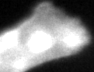
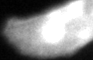
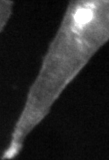

In [5]:
%%time
# view ALSF pediatric cancer atlas plate BR00143976 with images
CytoDataFrame(
    data=f"{pediatric_cancer_atlas_path}/BR00143976_shrunken.parquet",
    data_context_dir=f"{pediatric_cancer_atlas_path}/images/orig",
    data_outline_context_dir=f"{pediatric_cancer_atlas_path}/images/outlines",
    segmentation_file_regex={
        r"CellsOutlines_BR(\d+)_C(\d{2})_\d+\.tiff": r".*ch3.*\.tiff",
        r"NucleiOutlines_BR(\d+)_C(\d{2})_\d+\.tiff": r".*ch5.*\.tiff",
    },
    image_adjustment=adjust_contrast_subtly,
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Nuclei_Number_Object_Number",
        "Image_FileName_OrigAGP",
    ]
][
    :3
]

CPU times: user 289 ms, sys: 184 ms, total: 473 ms
Wall time: 122 ms


DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.


Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)


DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.


Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch5sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)


DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.


Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch5sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/pediatric_cancer_atlas_profiling/images/orig/r03c03f03p01-ch5sk1fk1fl1.tiff
Overlay image shape: (1080, 1080, 3)


,Metadata_ImageNumber,Metadata_Nuclei_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA
0,3,3,,
1,3,4,,
2,3,6,,

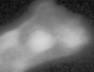
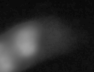
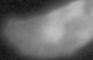
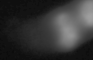
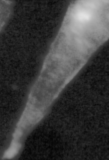
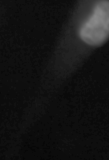

In [6]:
%%time
# view ALSF pediatric cancer atlas plate BR00143976 with images
CytoDataFrame(
    data=f"{pediatric_cancer_atlas_path}/BR00143976_shrunken.parquet",
    data_context_dir=f"{pediatric_cancer_atlas_path}/images/orig",
    data_outline_context_dir=f"{pediatric_cancer_atlas_path}/images/outlines",
    segmentation_file_regex={
        r"CellsOutlines_BR(\d+)_C(\d{2})_\d+\.tiff": r".*ch3.*\.tiff",
        r"NucleiOutlines_BR(\d+)_C(\d{2})_\d+\.tiff": r".*ch5.*\.tiff",
    },
    # image_adjustment=adjust_image_display,
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Nuclei_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
    ]
][
    :3
]

CPU times: user 707 ms, sys: 392 ms, total: 1.1 s
Wall time: 306 ms


,Metadata_ImageNumber,Cells_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA
0,1,1,,,
1,1,2,,,
2,1,3,,,

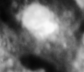
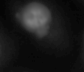
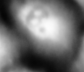
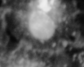
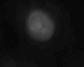
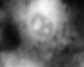
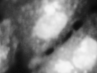
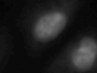
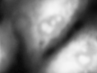

In [7]:
%%time
# view JUMP plate BR00117006 with images
CytoDataFrame(
    data=f"{jump_data_path}/BR00117006_shrunken.parquet",
    data_context_dir=f"{jump_data_path}/images/orig",
)[
    [
        "Metadata_ImageNumber",
        "Cells_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
][
    :3
]

CPU times: user 681 ms, sys: 424 ms, total: 1.1 s
Wall time: 292 ms
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch2sk1fk1fl1.tiff
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch2sk1fk1fl1.tiff


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 19055
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 19055
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 19055
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 19055
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.


Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch2sk1fk1fl1.tiff
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch5sk1fk1fl1.tiff
Overlay image shape: (1080, 1080)
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch5sk1fk1fl1.tiff
Overlay image shape: (1080, 1080)


DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 19055
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 19055
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 41467
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 41467
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.


Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch5sk1fk1fl1.tiff
Overlay image shape: (1080, 1080)
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080)


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 41467
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 41467
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 41467
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 41467
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:root:Base image and overlay image dimensions: (1080, 1080), (1080, 1080)
DEBUG:root:Applying Sobel edge detection for outline.
DEBUG:root:Dilation applied to edges.
DEBUG:root:Outline applied successfully.


Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080)
Original image shape: (1080, 1080)
Candidate path: ../../../tests/data/cytotable/JUMP_plate_BR00117006/images/orig/r01c01f01p01-ch3sk1fk1fl1.tiff
Overlay image shape: (1080, 1080)


,Metadata_ImageNumber,Cells_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA
0,1,1,,,
1,1,2,,,
2,1,3,,,

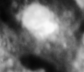
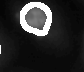
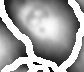
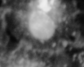
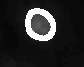
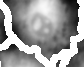
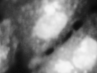
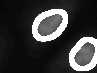
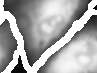

In [8]:
%%time
# view JUMP plate BR00117006 with images and overlaid outlines for segmentation
CytoDataFrame(
    data=f"{jump_data_path}/BR00117006_shrunken.parquet",
    data_context_dir=f"{jump_data_path}/images/orig",
    data_outline_context_dir=f"{jump_data_path}/images/outlines",
)[
    [
        "Metadata_ImageNumber",
        "Cells_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
][
    :3
]

CPU times: user 192 ms, sys: 87.8 ms, total: 280 ms
Wall time: 105 ms


,Metadata_ImageNumber,Metadata_Cells_Number_Object_Number,Image_FileName_GFP,Image_FileName_RFP,Image_FileName_DAPI
353,31,4,,,
1564,113,17,,,
1275,94,5,,,

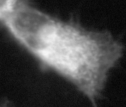
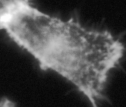
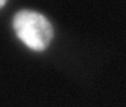
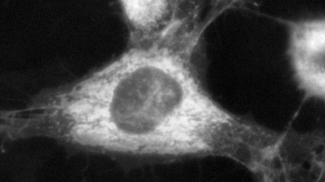
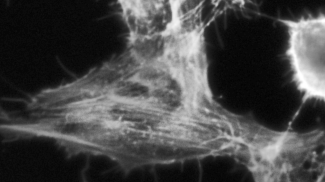
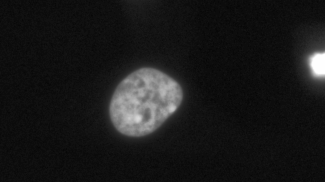
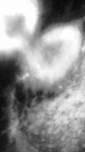
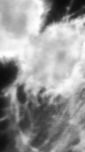
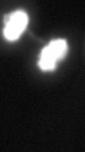

In [9]:
%%time
# view NF1 Cell Painting data with images
CytoDataFrame(
    data=f"{nf1_cellpainting_path}/Plate_2_with_image_data_shrunken.parquet",
    data_context_dir=f"{nf1_cellpainting_path}/Plate_2_images",
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Cells_Number_Object_Number",
        "Image_FileName_GFP",
        "Image_FileName_RFP",
        "Image_FileName_DAPI",
    ]
][
    :3
]

CPU times: user 206 ms, sys: 109 ms, total: 315 ms
Wall time: 103 ms
Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/B7_01_2_3_GFP_001.tif
Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/H12_01_2_1_GFP_001.tif


DEBUG:root:Base image and overlay image dimensions: (904, 1224), (904, 1224)
DEBUG:root:Mask applied successfully.
DEBUG:root:Base image and overlay image dimensions: (904, 1224), (904, 1224)
DEBUG:root:Mask applied successfully.


Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/F7_01_2_2_GFP_001.tif
Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/B7_01_3_3_RFP_001.tif
Overlay image shape: (904, 1224)
Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/H12_01_3_1_RFP_001.tif
Overlay image shape: (904, 1224)


DEBUG:root:Base image and overlay image dimensions: (904, 1224), (904, 1224)
DEBUG:root:Mask applied successfully.
DEBUG:root:Base image and overlay image dimensions: (904, 1224), (904, 1224)
DEBUG:root:Mask applied successfully.
DEBUG:root:Base image and overlay image dimensions: (904, 1224), (904, 1224)
DEBUG:root:Mask applied successfully.


Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/F7_01_3_2_RFP_001.tif
Overlay image shape: (904, 1224)
Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/B7_01_1_3_DAPI_001.tif
Overlay image shape: (904, 1224)
Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/H12_01_1_1_DAPI_001.tif
Overlay image shape: (904, 1224)


DEBUG:root:Base image and overlay image dimensions: (904, 1224), (904, 1224)
DEBUG:root:Mask applied successfully.


Original image shape: (904, 1224)
Candidate path: ../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/Plate_2_images/F7_01_1_2_DAPI_001.tif
Overlay image shape: (904, 1224)


,Metadata_ImageNumber,Metadata_Cells_Number_Object_Number,Image_FileName_GFP,Image_FileName_RFP,Image_FileName_DAPI
353,31,4,,,
1564,113,17,,,
1275,94,5,,,

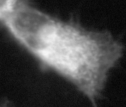
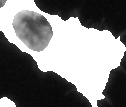
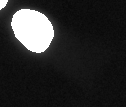
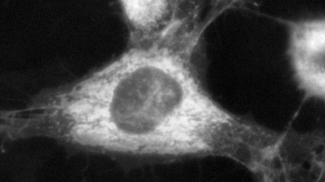
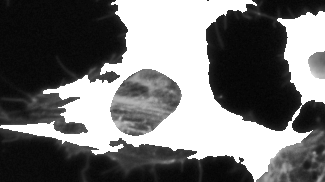
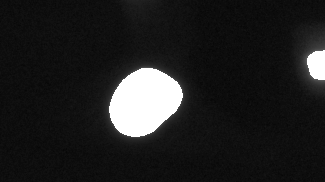
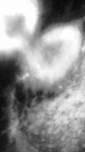
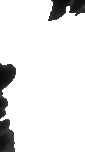
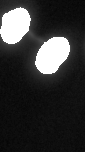

In [10]:
%%time
# view NF1 Cell Painting data with images and overlaid outlines from masks
CytoDataFrame(
    data=f"{nf1_cellpainting_path}/Plate_2_with_image_data_shrunken.parquet",
    data_context_dir=f"{nf1_cellpainting_path}/Plate_2_images",
    data_mask_context_dir=f"{nf1_cellpainting_path}/Plate_2_masks",
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Cells_Number_Object_Number",
        "Image_FileName_GFP",
        "Image_FileName_RFP",
        "Image_FileName_DAPI",
    ]
][
    :3
]

CPU times: user 96.5 ms, sys: 55.8 ms, total: 152 ms
Wall time: 48.9 ms


DEBUG:root:Base image and overlay image dimensions: (2304, 2304), (2304, 2304)
DEBUG:root:Mask applied successfully.


Original image shape: (2304, 2304)
Candidate path: ../../../tests/data/cytotable/nuclear_speckles/images/plate1/slide1_A1_M10_CH0_Z09_illumcorrect.tiff
Overlay image shape: (2304, 2304)


DEBUG:root:Base image and overlay image dimensions: (2304, 2304), (2304, 2304)
DEBUG:root:Mask applied successfully.


Original image shape: (2304, 2304)
Candidate path: ../../../tests/data/cytotable/nuclear_speckles/images/plate1/slide1_A1_M10_CH0_Z09_illumcorrect.tiff
Overlay image shape: (2304, 2304)


DEBUG:root:Base image and overlay image dimensions: (2304, 2304), (2304, 2304)
DEBUG:root:Mask applied successfully.


Original image shape: (2304, 2304)
Candidate path: ../../../tests/data/cytotable/nuclear_speckles/images/plate1/slide1_A1_M10_CH0_Z09_illumcorrect.tiff
Overlay image shape: (2304, 2304)


,Metadata_ImageNumber,Nuclei_Number_Object_Number,Image_FileName_A647,Image_FileName_DAPI,Image_FileName_GOLD
0,1,1,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff
1,1,2,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff
2,1,3,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff

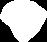
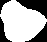

In [11]:
%%time
# view nuclear speckles data with images and overlaid outlines from masks
CytoDataFrame(
    data=f"{nuclear_speckles_path}/test_slide1_converted.parquet",
    data_context_dir=f"{nuclear_speckles_path}/images/plate1",
    data_mask_context_dir=f"{nuclear_speckles_path}/masks/plate1",
)[
    [
        "Metadata_ImageNumber",
        "Nuclei_Number_Object_Number",
        "Image_FileName_A647",
        "Image_FileName_DAPI",
        "Image_FileName_GOLD",
    ]
][
    :3
]